In [1]:
import copy
from cheat.game import CheatGame
from cheat.bots import RandomBot, SmartBot, LLM_Player
import numpy as np
import asyncio
import logging
import tqdm
import json
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt

import pandas as pd

from evaluate.styles import colors
plt.style.use(['evaluate.styles.default_style', 'evaluate.styles.font_garamond', 'evaluate.styles.font_size_12'])

## Bots-only

In [2]:
# Fill up with bots
def setup_game(num_players):
    game_players=[]
    for i in range(num_players):
        if i == 0:
            game_players.append(SmartBot(
                id=i,
                name=f'SmartBot',
                avatar='🌼',
                verbosity=0
            ))
        else:
            game_players.append(RandomBot(
                id=i,
                name=f'RandomBot_{i}',
                avatar='🌼',
                p_call=np.random.rand(),
                p_lie=np.random.rand(),
                verbosity=0
            ))

    # Set up a new game. Each game maintains its own message queue
    game = CheatGame(
        players=game_players,
        experimental_mode=False,
        game_mode='single',
        message_queue = asyncio.Queue(), # Set up a new queue
        out_dir=None
    )
    game.logger.setLevel(logging.WARN)
    game.player_logger.setLevel(logging.WARN)
    return game

In [3]:
game = setup_game(num_players=6)

In [4]:
# Play 10 rounds
n_rounds = 10
for i in tqdm.trange(n_rounds):
    await game.play_round(sleep_pause=0)
    # winner_properties.append((game.players[game.winner].p_call, game.players[game.winner].p_lie))
    if i < n_rounds-1:
        game.new_round()
    else:
        game.game_over = True

100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


Text(0.5, 1.15, "SmartBot's internal model of the other players over time")

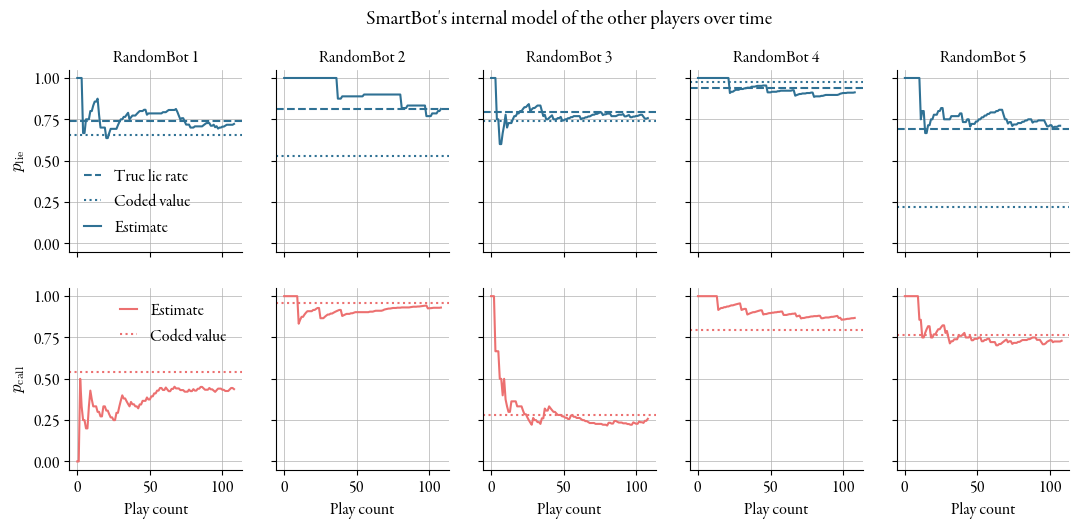

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=game.num_players-1, figsize=(10, 4), sharey=True, sharex=True)
axs= axs.reshape(2, -1)
for idx, p in enumerate(game.players):
    if idx == 0:
        continue
    axs[0, idx-1].axhline(1-len([action for action in game.history if action.type == 'play' and action.player_id == p.id and all([action.data['declared_rank'] == c.rank for c in action.data['cards_played']])]) / len([action for action in game.history if action.type == 'play' and action.player_id == p.id]), ls='dashed', label='True lie rate'
    )
    axs[0, idx-1].axhline(p.p_lie, ls='dotted', label='Coded value')

    axs[0, idx-1].plot(game.players[0].other_player_repr_hist[idx]['p_lie_est'], label='Estimate')
    axs[1, idx-1].plot(game.players[0].other_player_repr_hist[idx]['p_call_est'], c=colors['c_red'], label='Estimate')
    axs[1, idx-1].axhline(p.p_call, ls='dotted', c=colors['c_red'], label='Coded value')
    axs[0, idx-1].set(title=f"RandomBot {idx}")
    axs[1, idx-1].set(xlabel='Play count')
axs[0, 0].set(ylabel=r'$p_{\mathrm{lie}}$')
axs[1, 0].set(ylabel=r'$p_\mathrm{call}$')
axs[0, 0].legend()
axs[1, 0].legend()
fig.suptitle("SmartBot's internal model of the other players over time", y=1.15)

In [50]:
winners = []
lie_rate = []
call_rate = []

In [51]:
# Play 100 games with 10 rounds each
n_games = 100
n_rounds = 10
for _ in tqdm.trange(n_games):
    game = setup_game(num_players=6)
    game_winners = []
    game_p_lie = []
    game_p_call = []
    for i in range(n_rounds):
        await game.play_round(sleep_pause=0)
        game_winners.append(game.winner)

        # Estimated call rate
        game_p_call.append(game.players[0].other_player_repr[0].get('p_call_est', np.nan))

        # Estimate lie rate
        _l, _p = 0, 0
        for action in game.history[::-1]:
            if action.type == 'new_round':
                break
            if action.type == 'play' and action.player_id == 0:
                _p += 1
            if action.type == 'play' and action.player_id == 0 and not all([c.rank == action.data['declared_rank'] for c in action.data['cards_played']]):
                _l += 1
        game_p_lie.append(_l/_p)
        #game_p_lie.append(game.players[0].other_player_repr[0]['p_lie_est'])
        game.new_round()
    winners.append(game_winners)
    lie_rate.append(game_p_lie)
    call_rate.append(game_p_call)

100%|██████████| 100/100 [1:38:26<00:00, 59.07s/it]


Text(0.5, 1.15, 'Is SmartBot better than a random bot?')

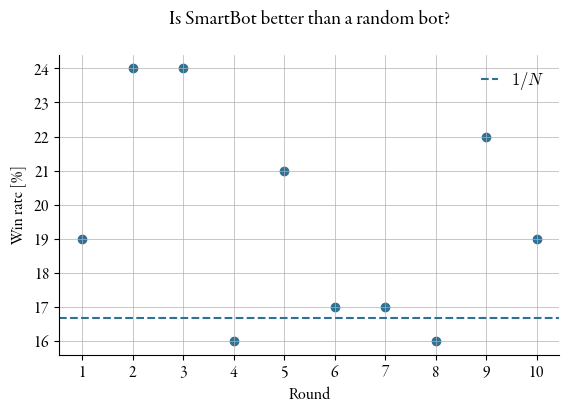

In [52]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(np.arange(np.stack(winners).shape[1])+1, 100*(np.stack(winners)==0).sum(axis=0) / np.stack(winners).shape[0])
ax.set(ylabel='Win rate [%]', xlabel='Round')
ax.axhline(100*1/6, ls='dashed', label=r'$1/N$')
ax.legend()
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle("Is SmartBot better than a random bot?", y=1.15)

Text(0.5, 1.21, "How does SmartBot's strategy evolve over time?")

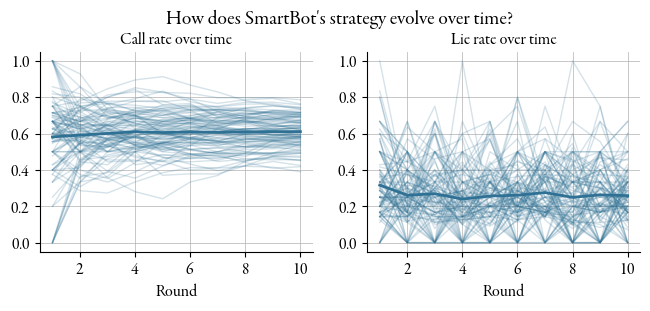

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 2))
axs[0].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(call_rate).T, c=colors['c_darkblue'], alpha=0.2, lw=1)
axs[0].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(call_rate).T.mean(axis=1), c=colors['c_darkblue'], lw=2)
axs[0].set(xlabel='Round', title="Call rate over time")
axs[1].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(lie_rate).T, c=colors['c_darkblue'], alpha=0.2, lw=1)
axs[1].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(lie_rate).T.mean(axis=1), c=colors['c_darkblue'], lw=2)
axs[1].set(xlabel='Round', title="Lie rate over time")
fig.suptitle("How does SmartBot's strategy evolve over time?", y=1.21)

In [ ]:
# data = np.array(winner_properties)
# x, y = data[:,0], data[:,1]
# # Define bin edges
# xbins = np.linspace(x.min(), x.max(), 10)   # 50 bins
# ybins = np.linspace(y.min(), y.max(), 10)
#
# # 2D counts
# counts, _, _, _ = binned_statistic_2d(
#     x, y, None, statistic='count', bins=[xbins, ybins]
# )
#
# plt.imshow(
#     counts.T,
#     origin='lower',
#     extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
#     aspect='auto'
# )
# plt.colorbar(label='count')
# plt.xlabel('p_call')
# plt.ylabel('p_lie')
# plt.show()

## Mixed LLM-bot game

In [ ]:
N_players = 6

system_prompt_template = "You are playing Cheat with {N_players} other players. You are Player {player_id}. Goal: get rid of all cards. On your turn: play 1-3 cards face down and declare a rank (Aces cannot be declared). You can bluff - cards don't need to match declaration. Options: 'Call' (challenge previous play), 'Play [cards]' (follow current rank), or 'Play [cards]; Declare rank' (start new rank when pile empty). Four-of-a-kind auto-discard. Win by emptying hand. FORMAT REQUIREMENTS: - Respond ONLY with: 'Call', 'Play [card1, card2]', or 'Play [cards]; Declare rank' - Use J/Q/K/A for face cards - Examples: 'Play [4♣, 4♦]; Declare 4', 'Play [A♠, K♥]', 'Play [2♥, J♣]; Declare J' - NO extra text: backend parsing depends on exact format."

In [ ]:
# Fill up with bots
game_players=[]
for i in range(N_players):
    if i == 0:
        game_players.append(LLM_Player(
            id=i,
            name=f'DeepSeek',
            avatar='🤖',
            system_prompt = system_prompt_template.format(N_players=N_players-1,  player_id=i),
            kind='deepseek',
            model_kwargs=dict(model='deepseek-chat', stream=False)
        ))
    else:
        game_players.append(SmartBot(
            id=i,
            name=f'SmartBot_{i}',
            avatar='🌼',
            #p_call=np.random.rand(),
            #p_lie=np.random.rand(),
            verbosity=0
        ))
    # if i == 0:
    #     game_players.append(LLM_Player(
    #         id=i,
    #         name=f'ChatGPT',
    #         avatar='🌼',
    #         init_prompt = dict(
    #         kind='open_ai',
    #         model='gpt-5-nano'
    #     ))

    # elif i == 2:
    #     game_players.append(LLM_Player(
    #         id=i,
    #         name=f'Google Gemini',
    #         avatar='🌼',
    #         init_prompt = input_prompt,
    #         kind='gemini',
    #         model='gemini-3-pro-preview'
    #     ))
# Set up a new game. Each game maintains its own message queue
game = CheatGame(
    players=game_players,
    experimental_mode=False,
    game_mode='single',
    message_queue = asyncio.Queue(), # Set up a new queue
    out_dir="game_data"
)

In [ ]:
n_rounds = 10
for i in tqdm.trange(n_rounds):
    await game.play_round(sleep_pause=0)
    if i != n_rounds-1:
        game.new_round()

In [ ]:
# Reconstruct a DataFrame for each round
with open(f"{game.out_path}/game_history.jsonl", "r") as f:
    game_history = [json.loads(line) for line in f if line.strip()]

In [ ]:
def deep_copy_row(df_row):
    """Create a deep copy of a DataFrame row with list columns"""
    row_dict = df_row.to_dict()
    for key, value in row_dict.items():
        if isinstance(value, list):
            row_dict[key] = value.copy()
    return pd.Series(row_dict)

In [ ]:
from cheat.card import RANK_ORDER

In [ ]:
game_data = pd.DataFrame(columns=['game_id', 'round', 'state', 'Pile', 'Discards'] + [f'Player {p.id}' for p in game.players])
for record in game_history:

    # New round: write initial state
    if record['type'] == 'new_round':
        # Extract data
        game_id = record['game_id']
        round_num = record['round']
        state = record['type']  # 'new_round'

        # Extract player hands from the nested data
        player_hands = record['data']['player_hands']

        # Create row data - fill player columns with their hand strings
        row_data = {
            'game_id': game_id,
            'round': round_num,
            'state': state,
            'Player': '',
            'Current rank': None,
            'Pile': [],  # Not in this record
            'Discards': []  # Not in this record
        }

        # Add player hand columns
        for player_key, hand in player_hands.items():
            # player_key is '0', '1', etc.
            # Convert hand list to string representation
            row_data[f'Player {player_key}'] = copy.deepcopy(hand) if hand else []

        # Fill missing player columns with empty string
        for i in range(4):  # Assuming 4 players
            col_name = f'Player {i}'
            if col_name not in row_data:
                row_data[col_name] = ''

        # Create DataFrame row and append
        row_df = pd.DataFrame([row_data])
        game_data = pd.concat([game_data, row_df], ignore_index=True)

    # Play: move played cards from Players hands to pile
    elif record['type'] == 'play':
        row_df = deep_copy_row(game_data.iloc[-1])
        row_df['state'] = 'play'
        row_df['Player'] = record['player_id']
        row_df['Current rank'] = record['data']['declared_rank']
        cards_played = record['data']['cards_played']
        for c in cards_played:
            row_df[f"Player {record['player_id']}"].remove(c)
            row_df["Pile"].append(c)
        game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

    # Call: move pile from Players who successfully called
    elif record['type'] == 'call':
        row_df = deep_copy_row(game_data.iloc[-1])
        row_df['state'] = 'call'
        row_df['Current rank'] = None
        row_df['Player'] = record['player_id']
        accused_id = record['data']['accused_id']
        if record['data']['was_lying']:
            add_to_player = f"Player {record['data']['accused_id']}"
        else:
            add_to_player = f"Player {record['player_id']}"
        row_df[add_to_player].extend(row_df['Pile'])
        row_df[add_to_player] = sorted(row_df[add_to_player], key=lambda c: RANK_ORDER[c[:-1]])
        row_df['Pile'] = []

        game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

    # Discards
    elif record['type'] == 'discard':
        row_df = deep_copy_row(game_data.iloc[-1])
        row_df['Player'] = record['player_id']
        row_df['state'] = 'discard'

        row_df['Discards'].extend([c for c in row_df[f"Player {record['player_id']}"] if c[:-1] in record['data']])
        row_df[f"Player {record['player_id']}"] = [c for c in row_df[f"Player {record['player_id']}"] if c[:-1] not in record['data']]
        game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

In [ ]:
fig, axs = plt.subplots(figsize=(8, 5), ncols=3, nrows=4, sharex=True, sharey=True)
for idx in game_data['round'].unique()[:-1]:
    game_data[game_data['round']==idx][['Player 0', 'Player 1', 'Player 2', 'Player 3', 'Player 4', 'Player 5']].map(len).rename({"Player 0": "DeepSeek", "Player 1": "SmartBot 1", "Player 2": "SmartBot 2", "Player 3": "SmartBot 3", "Player 4": "SmartBot 4", "Player 5": "SmartBot 5"}, axis=1).reset_index(drop=True).plot(ax=axs.flatten()[idx-1], legend=idx==1)
    axs.flatten()[idx-1].set(ylabel='Number of cards', xlabel='Play')
    axs.flatten()[idx-1].axhline(3, ls='dotted')